## Downloading Dataset
- Download zip file with gdown library
- Unzip dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import gdown
! gdown https://drive.google.com/u/0/uc?id=0B_jQiLugGTAkMDQ5ZjZiMTUtMzQ1Yy00YWNmLWJlZDYtOWY1ZDMwY2U4YjFk&export=download
!unzip /content/SemEval2010_task8_all_data.zip


Downloading...
From: https://drive.google.com/u/0/uc?id=0B_jQiLugGTAkMDQ5ZjZiMTUtMzQ1Yy00YWNmLWJlZDYtOWY1ZDMwY2U4YjFk
To: /content/SemEval2010_task8_all_data.zip
100% 1.96M/1.96M [00:00<00:00, 5.39MB/s]
Archive:  /content/SemEval2010_task8_all_data.zip
   creating: SemEval2010_task8_all_data/
   creating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/answer_key1.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/answer_key2.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/answer_key3.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/answer_key5.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/proposed_answer1.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/proposed_answer2.txt  
  inflating: SemEval2010_task8_all_data/SemEval2010_task8_scorer-v1.2/proposed_answer3.txt  
  in

## Preprocessing
- reading data
- encode labels
- tokenize & extract entities
- extract index of entities (for part C)
- replace entities with sentences
- create vocabulary
- vectorize sentennces


### reading data: 
read text file (sentences and relations)

In [2]:
def read_txt(path):
    with open(path, 'r') as rf:
        lines = rf.readlines()
        li = 0
        sentences = []
        relations = []
        for i in range(0,len(lines), 4):
            sentences.append(lines[i])
            relations.append(lines[i+1])
    print(len(sentences), len(relations))
    return sentences, relations

In [3]:
train_sentences, train_relations = read_txt('/content/SemEval2010_task8_all_data/SemEval2010_task8_training/TRAIN_FILE.TXT')
test_sentences, test_relations = read_txt('/content/SemEval2010_task8_all_data/SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT')

8000 8000
2717 2717


In [4]:
print(train_sentences[:2])
print(train_relations[:2])

['1\t"The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>."\n', '2\t"The <e1>child</e1> was carefully wrapped and bound into the <e2>cradle</e2> by means of a cord."\n']
['Component-Whole(e2,e1)\n', 'Other\n']


### Encode labels: 
first clean relations from additional characters like (e1,e2) and \n for train and test data 


> for example: 'Component-Whole(e2,e1)\n' &#8594;  'Component-Whole'






In [5]:
from nltk.tokenize import RegexpTokenizer #for tokenizer
import re # for regex

In [6]:
for i in range(len(train_relations)):
  if train_relations[i] == 'Other\n':
    train_relations[i] = train_relations[i][:-1]
    continue
  train_relations[i] = train_relations[i][:-8]
for i in range(len(test_relations)):
  if test_relations[i] == 'Other\n':
    test_relations[i] = test_relations[i][:-1]
    continue
  test_relations[i] = test_relations[i][:-8]

In [7]:
OTHER_LABEL = 'Other'   
unique_set = set(test_relations + train_relations)
unique_set.remove(OTHER_LABEL)
unique_relations = list(unique_set)
unique_relations.append(OTHER_LABEL)
print(len(train_relations), train_relations[:3])
print(len(test_relations), test_relations[:3])
print(len(unique_relations), unique_relations)

8000 ['Component-Whole', 'Other', 'Instrument-Agency']
2717 ['Message-Topic', 'Product-Producer', 'Instrument-Agency']
10 ['Cause-Effect', 'Member-Collection', 'Content-Container', 'Entity-Origin', 'Entity-Destination', 'Component-Whole', 'Message-Topic', 'Instrument-Agency', 'Product-Producer', 'Other']


encode relations into numbers

In [8]:
rel2lb = {}
lb2rel = {}
for i,item in enumerate(unique_relations):
    rel2lb[item] = i
    lb2rel[i] = item
train_labels = [rel2lb[item] for item in train_relations]
test_labels = [rel2lb[item] for item in test_relations]


In [9]:
print(len(train_labels), len(test_labels))
print(train_labels[:3])
print(train_relations[:3])

8000 2717
[5, 9, 7]
['Component-Whole', 'Other', 'Instrument-Agency']


### tokenize & extract entities:
find entities between 2 special tags, extract entities and replace entities with special characters. at the end tokenize the remaining sentences.

In [10]:
e1pt = re.compile('<e1>.*</e1>')
e2pt = re.compile('<e2>.*</e2>')
E1LABEL = ' E1LABEL '
E2LABEL = ' E2LABEL '

def process_sentence(sentence):
    # regex replace
    sentence = re.sub('\d*\t\"', "", sentence) # delete qutation marks and numbers and \t from first of sentence
    sentence = sentence[:-2]
    e1 = e1pt.search(sentence) # find and replace first entity with ' E1LABEL '
    sentence = re.sub(e1pt, E1LABEL, sentence)
    e2 = e2pt.search(sentence) # find and replace second entity with ' E2LABEL '
    sentence = re.sub(e2pt, E2LABEL, sentence) 
    sentence = re.sub(' \d+', "", sentence) # delete numbers
    # split word and filter punctuations
    tokenizer = RegexpTokenizer(r'\w+')
    words = [token for token in tokenizer.tokenize(sentence)]
    return sentence, (e1.group(0)[4:-5].split(),e2.group(0)[4:-5].split()), words

def process_sentence_group(org_sentences):
    entities = []
    words_list = []
    processed_sentences = []
    for i in range(len(org_sentences)):
        sentence = org_sentences[i]
        sentence, entity, words =  process_sentence(sentence)
        entities.append(entity)
        words_list.append(words)
        processed_sentences.append(sentence)
        if (i%100 == 0):
            print('\rfinished {}'.format(i),flush=True, end='')
    print('')
    return processed_sentences, entities, words_list



In [11]:
train_processed, train_entities, train_words = process_sentence_group(train_sentences)
test_processed, test_entities, test_words = process_sentence_group(test_sentences)

finished 7900
finished 2700


In [12]:
print(train_processed[:3])
print(train_entities[:3])
print(train_words[:3])

['The system as described above has its greatest application in an arrayed  E1LABEL  of antenna  E2LABEL .', 'The  E1LABEL  was carefully wrapped and bound into the  E2LABEL  by means of a cord.', 'The  E1LABEL  of a keygen uses a  E2LABEL  to look at the raw assembly code.']
[(['configuration'], ['elements']), (['child'], ['cradle']), (['author'], ['disassembler'])]
[['The', 'system', 'as', 'described', 'above', 'has', 'its', 'greatest', 'application', 'in', 'an', 'arrayed', 'E1LABEL', 'of', 'antenna', 'E2LABEL'], ['The', 'E1LABEL', 'was', 'carefully', 'wrapped', 'and', 'bound', 'into', 'the', 'E2LABEL', 'by', 'means', 'of', 'a', 'cord'], ['The', 'E1LABEL', 'of', 'a', 'keygen', 'uses', 'a', 'E2LABEL', 'to', 'look', 'at', 'the', 'raw', 'assembly', 'code']]


### extract index of entities (for part C):
extract index of entities from sentences and save them as a list

In [13]:
def extract_indexs(org_words, entities):
    word_idxs = []
    count = 0
    for i  in range(len(org_words)):
        idx1 = []
        idx2 = []
        for j in range(len(org_words[i])):
            if org_words[i][j] == 'E1LABEL':
                idx1 = [item for item in range(j,j+len(entities[i][0]))]
            if org_words[i][j] == 'E2LABEL':
                idx2 = [item for item in range(j,j+len(entities[i][1]))]
        word_idxs.append([idx1, idx2])
    return  word_idxs

train_idxs = extract_indexs(train_words, train_entities)
test_idxs = extract_indexs(test_words,test_entities)

In [14]:
train_idxs[:3]

[[[12], [15]], [[1], [9]], [[1], [7]]]

### replace entities with sentences:
replace entitis with special characters of each entity 

In [15]:
def replace_word(org_list, org_word_list):
    new_list = []
    for i in range(len(org_list)):
        e1 = org_list[i][0]
        e2 = org_list[i][1]
        new_list.append((e1,e2))
        for j in range(len(org_word_list[i])):
            if org_word_list[i][j] == 'E1LABEL':
                org_word_list[i][j] = e1
            elif org_word_list[i][j] == 'E2LABEL':
                org_word_list[i][j] = e2
            else:
              org_word_list[i][j] = [org_word_list[i][j]]
        if i%100 == 0:
            print('\rfinished {}'.format(i), flush=True, end='')
    print('')
    words = [[j for i in item for j in i] for item in org_word_list]
    return new_list,words

train_entities,train_words = replace_word(train_entities, train_words)
test_entities,test_words = replace_word(test_entities, test_words)
print(train_entities[:3])
print(train_words[:3])

finished 7900
finished 2700
[(['configuration'], ['elements']), (['child'], ['cradle']), (['author'], ['disassembler'])]
[['The', 'system', 'as', 'described', 'above', 'has', 'its', 'greatest', 'application', 'in', 'an', 'arrayed', 'configuration', 'of', 'antenna', 'elements'], ['The', 'child', 'was', 'carefully', 'wrapped', 'and', 'bound', 'into', 'the', 'cradle', 'by', 'means', 'of', 'a', 'cord'], ['The', 'author', 'of', 'a', 'keygen', 'uses', 'a', 'disassembler', 'to', 'look', 'at', 'the', 'raw', 'assembly', 'code']]


### create vocabulary

In [16]:
unique_words = list(set([w for item in train_words+test_words for w in item]))
unique_words.append('<unknown_word>')
unique_words.append('<padding_word>')
unknown_idx = len(unique_words) - 2
padding_idx = len(unique_words) - 1

In [17]:
word2idx = {}
idx2word = {}
for i,w in enumerate(unique_words):
    word2idx[w] = i
    idx2word[i] = w
print(len(word2idx), len(idx2word))

24372 24372


### vectorize sentennces

In [18]:
train_words_vec = [[word2idx[item] if item in word2idx else unknown_idx for item in i] for i in train_words]

In [19]:
test_words_vec = [[word2idx[item] if item in word2idx else unknown_idx for item in i] for i in test_words]

## create Realtion Extraction model (part A,B and C)
- build a data loader for train, validation and test
- define a random or Glove embedding weights
- create bi-LSTM model
- train and validate network for some epochs
- test and evaluate model

In [20]:
#imports 
import os
from collections import Counter
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
from nltk.tokenize import RegexpTokenizer #for tokenizer
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [21]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

## part A)

### build a data loader for train, validation and test
first create train and test dataset, then split train dataset into train and validation sets and finally create a dataloader for each of them.
> we choose 7110 sentance of train dataset because of balance labels in this number of sentences. 


In [22]:
train_data = [[torch.tensor(train_words_vec[i]), torch.tensor([train_labels[i]])] for i in range(len(train_labels))][:7110]

In [23]:
test_data = [[torch.tensor(test_words_vec[i]), torch.tensor([test_labels[i]])] for i in range(len(test_labels))]

In [24]:
train_set, val_set = torch.utils.data.random_split(train_data, [6600, 510])

In [25]:
def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]
  global padding_idx
  xx_pad = pad_sequence(xx, batch_first=True, padding_value=padding_idx)

  return xx_pad, yy

In [26]:
data_loader = DataLoader(
    dataset=train_set,
    batch_size=128,
    shuffle=True,
    collate_fn=pad_collate
)

In [27]:
validation_loader = DataLoader(
    dataset=val_set,
    batch_size=128,
    shuffle=True,
    collate_fn=pad_collate
)

In [28]:
test_loader = DataLoader(
    dataset=test_data,
    batch_size=128,
    shuffle=True,
    collate_fn=pad_collate
)

### define a random  embedding weights

In [29]:
embedding_matrixs = np.random.randn(len(word2idx),100)

### create bi-LSTM model

In [36]:
class BiLSTM(nn.Module):
    
    def __init__(self, embeding_size, vocab_size,num_layer, hidden_size, num_classes, embedding_weights, grad_embedding=True):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        drp = 0.1
        n_classes = num_classes
        self.embedding = nn.Embedding(vocab_size, embeding_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_weights, dtype=torch.float32).to(device)) # input_size = embed_size,num_layers = 2, hidden_size = self.hidden_size, bidirectional=True, batch_first=True
        self.embedding.weight.requires_grad = grad_embedding
        self.lstm = nn.LSTM(input_size=embed_size,num_layers = num_layer, hidden_size= self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*2 , 10)
        self.softmax = nn.LogSoftmax(dim=1)
        


    def forward(self, x):
        h_embedding = self.embedding(x)
        packed_output, (hidden, cell) = self.lstm(h_embedding)
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        conc = self.softmax(self.linear(cat))
        return conc

### train and validate network for some epochs

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [42]:
embed_size = embedding_matrixs.shape[1]
hidden_size=150
num_layers=2
vocab_size = embedding_matrixs.shape[0]


In [49]:
model = BiLSTM(embed_size, vocab_size, num_layers,hidden_size, 10, embedding_matrixs) # embeding_size, vocab_size,num_layer, hidden_size, num_classes, embedding_weights

In [50]:
model.to(device)

BiLSTM(
  (embedding): Embedding(24372, 100)
  (lstm): LSTM(100, 150, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=300, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [51]:
criterion = nn.NLLLoss(ignore_index=padding_idx)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)

In [52]:
import time
start_time = time.time()
num_epochs = 25
train_loss = []
validation_loss = []
train_acc=[]
val_acc = []
for epoch in range(num_epochs):
  running_loss = 0
  running_acc=0
  #print_examples(model, device, dataset)
  for idx, (sentence, label) in enumerate(iter(data_loader)):
    sentence, label = sentence.to(device),torch.tensor(list(label)).to(device)
    model.train()
    optimizer.zero_grad()
    # Feed forward
    outputs = model(sentence)
    # Calculate the batch loss.
    pred = torch.argmax(outputs, dim=1)
    running_acc += sum(pred==label).item() /len(label)
    loss = criterion(outputs, label)
    # Backward pass.
    loss.backward()
    # Update the parameters in the optimizer.
    optimizer.step()   
    running_loss += loss.item()
  model.eval()
  running_loss_valid = 0.0
  running_acc_valid = 0.0
  for jdx, (sentence, label) in enumerate(iter(validation_loader)):
    sentence, label = sentence.to(device),torch.tensor(list(label)).to(device)
    
    # Feed forward
    outputs = model(sentence)
    
    loss = criterion(outputs, label)
      
    running_loss_valid += loss.item()

    pred = torch.argmax(outputs, dim=1)
    
    running_acc_valid += sum(pred==label).item()/len(label)


  print(f'epoch: {epoch} -  train loss: {running_loss / (idx+1)} - validation loss: {running_loss_valid/(jdx+1)} - train acc = {running_acc/(idx+1)} - validation acc = {running_acc_valid/(jdx+1)}')
  train_loss.append(running_loss / (idx+1))
  validation_loss.append(running_loss_valid/(jdx+1))
  train_acc.append(running_acc/(idx+1))
  val_acc.append(running_acc_valid/(jdx+1))
  torch.save(model.cpu().state_dict(), 'final_model.pth') # saving model
  model.to(device)

running_time = time.time()-start_time
print(f'training Finished in {running_time} seconds')

epoch: 0 -  train loss: 2.258029369207529 - validation loss: 2.1950308680534363 - train acc = 0.16010616987179488 - validation acc = 0.20380704365079366
epoch: 1 -  train loss: 2.081626151616757 - validation loss: 1.9658942222595215 - train acc = 0.24884815705128205 - validation acc = 0.3038194444444444
epoch: 2 -  train loss: 1.87059581050506 - validation loss: 1.8512234091758728 - train acc = 0.3382077991452992 - validation acc = 0.3038504464285714
epoch: 3 -  train loss: 1.724199489905284 - validation loss: 1.7770909667015076 - train acc = 0.38463207799145305 - validation acc = 0.3842385912698413
epoch: 4 -  train loss: 1.60325799538539 - validation loss: 1.6951248347759247 - train acc = 0.433326655982906 - validation acc = 0.4056919642857143
epoch: 5 -  train loss: 1.5126860325153058 - validation loss: 1.6618730425834656 - train acc = 0.4668135683760684 - validation acc = 0.40987723214285715
epoch: 6 -  train loss: 1.4453264818741725 - validation loss: 1.6079755425453186 - train ac

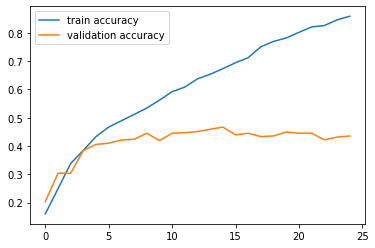

In [53]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(["train accuracy", "validation accuracy"])
plt.show()

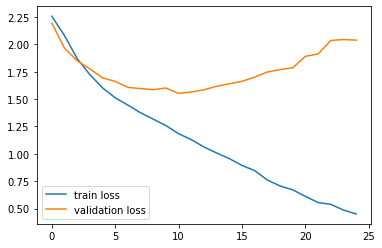

In [54]:
plt.plot(train_loss)
plt.plot(validation_loss)
plt.legend(["train loss", "validation loss"])
plt.show()

### test and evaluate model

In [55]:
y_pred= []
y_label=[]
with torch.no_grad():
  for jdx, (sentence, label) in enumerate(iter(test_loader)):
    sentence, label = sentence.to(device),torch.tensor(list(label)).to(device)
    # Feed forward
    outputs = model(sentence)
    pred = torch.argmax(outputs, dim=1)
    for i in range(len(label)):
      y_pred.append(pred[i].item())
      y_label.append(label[i].item())


In [56]:
print(f'''accuracy: {accuracy_score(y_label, y_pred, normalize=True)} 
\nprecision:{precision_score(y_label, y_pred, average='macro')} 
\nrecall: {precision_score(y_label, y_pred, average='macro')} 
\nf1 score: {f1_score(y_label, y_pred, average='macro')}''')

accuracy: 0.5012881854987118 

precision:0.5147119826349587 

recall: 0.5147119826349587 

f1 score: 0.5016357706752271


## part B)
use dataloaders and model from part A  

### define  Glove embedding weights

In [58]:
! gdown http://nlp.stanford.edu/data/glove.42B.300d.zip

Downloading...
From: http://nlp.stanford.edu/data/glove.42B.300d.zip
To: /content/glove.42B.300d.zip
100% 1.88G/1.88G [05:55<00:00, 5.29MB/s]


In [59]:
! unzip /content/glove.42B.300d.zip

Archive:  /content/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [60]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule
import numpy as np
def load_glove(word_index):
    max_feature=27000
    EMBEDDING_FILE = '/content/glove.42B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_feature, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_feature: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [61]:
embedding_matrix = load_glove(word2idx)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


### train and validate network for some epochs

In [62]:
embed_size = embedding_matrix.shape[1]
hidden_size=150
num_layers=2
vocab_size = embedding_matrix.shape[0]


In [63]:
Glove_model = BiLSTM(embed_size, vocab_size, num_layers,hidden_size, 10, embedding_matrix, grad_embedding=False) 

In [64]:
criterion = nn.NLLLoss(ignore_index=padding_idx)
optimizer = optim.Adam(Glove_model.parameters(), lr=0.0005, weight_decay=0.0005)

In [67]:
Glove_model.to(device)

BiLSTM(
  (embedding): Embedding(24373, 300)
  (lstm): LSTM(300, 150, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=300, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [68]:
import time
start_time = time.time()
num_epochs = 25
train_glove_loss = []
validation_glove_loss = []
train_glove_acc=[]
val_glove_acc = []
for epoch in range(num_epochs):
  running_loss = 0
  running_acc=0
  #print_examples(model, device, dataset)
  for idx, (sentence, label) in enumerate(iter(data_loader)):
    sentence, label = sentence.to(device),torch.tensor(list(label)).to(device)
    Glove_model.train()
    optimizer.zero_grad()
    # Feed forward
    outputs = Glove_model(sentence)
    # Calculate the batch loss.
    pred = torch.argmax(outputs, dim=1)
    running_acc += sum(pred==label).item() /len(label)
    loss = criterion(outputs, label)
    # Backward pass.
    loss.backward()
    # Update the parameters in the optimizer.
    optimizer.step()   
    running_loss += loss.item()
  Glove_model.eval()
  running_loss_valid = 0.0
  running_acc_valid = 0.0
  for jdx, (sentence, label) in enumerate(iter(validation_loader)):
    sentence, label = sentence.to(device),torch.tensor(list(label)).to(device)
    
    # Feed forward
    outputs = Glove_model(sentence)
    
    loss = criterion(outputs, label)
      
    running_loss_valid += loss.item()

    pred = torch.argmax(outputs, dim=1)
    
    running_acc_valid += sum(pred==label).item()/len(label)


  print(f'epoch: {epoch} -  train loss: {running_loss / (idx+1)} - validation loss: {running_loss_valid/(jdx+1)} - train acc = {running_acc/(idx+1)} - validation acc = {running_acc_valid/(jdx+1)}')
  train_glove_loss.append(running_loss / (idx+1))
  validation_glove_loss.append(running_loss_valid/(jdx+1))
  train_glove_acc.append(running_acc/(idx+1))
  val_glove_acc.append(running_acc_valid/(jdx+1))
  torch.save(Glove_model.cpu().state_dict(), 'final_model.pth') # saving model
  Glove_model.to(device)

running_time = time.time()-start_time
print(f'training Finished in {running_time} seconds')

epoch: 0 -  train loss: 2.175556148474033 - validation loss: 1.8862315118312836 - train acc = 0.20708133012820512 - validation acc = 0.31178695436507936
epoch: 1 -  train loss: 1.6163101929884691 - validation loss: 1.397066593170166 - train acc = 0.4280348557692308 - validation acc = 0.5390625
epoch: 2 -  train loss: 1.2807922615454748 - validation loss: 1.2766124904155731 - train acc = 0.5551382211538461 - validation acc = 0.5529823908730158
epoch: 3 -  train loss: 1.1169690696092753 - validation loss: 1.1767999231815338 - train acc = 0.6139656784188035 - validation acc = 0.5863715277777778
epoch: 4 -  train loss: 0.9992263064934657 - validation loss: 1.1286509931087494 - train acc = 0.6537293002136753 - validation acc = 0.5940600198412699
epoch: 5 -  train loss: 0.9196080668614461 - validation loss: 1.0850259065628052 - train acc = 0.6870325854700854 - validation acc = 0.6274181547619048
epoch: 6 -  train loss: 0.8378197527848757 - validation loss: 1.1321394443511963 - train acc = 0.

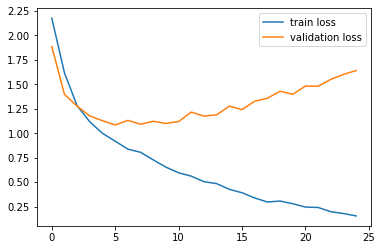

In [69]:
plt.plot(train_glove_loss)
plt.plot(validation_glove_loss)
plt.legend(["train loss", "validation loss"])
plt.show()

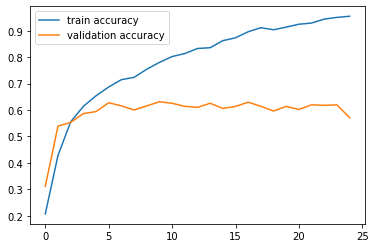

In [70]:
plt.plot(train_glove_acc)
plt.plot(val_glove_acc)
plt.legend(["train accuracy", "validation accuracy"])
plt.show()

### test and evaluate model

In [71]:
y_pred_glove= []
y_label_glove=[]
with torch.no_grad():
  for jdx, (sentence, label) in enumerate(iter(test_loader)):
    sentence, label = sentence.to(device),torch.tensor(list(label)).to(device)
    # Feed forward
    outputs = Glove_model(sentence)
    pred = torch.argmax(outputs, dim=1)
    for i in range(len(label)):
      y_pred_glove.append(pred[i].item())
      y_label_glove.append(label[i].item())


In [72]:
print(f'''accuracy: {accuracy_score(y_label_glove, y_pred_glove, normalize=True)} 
\nprecision:{precision_score(y_label_glove, y_pred_glove, average='macro')} 
\nrecall: {precision_score(y_label_glove, y_pred_glove, average='macro')} 
\nf1 score: {f1_score(y_label_glove, y_pred_glove, average='macro')}''')

accuracy: 0.6017666543982333 

precision:0.6314459948725772 

recall: 0.6314459948725772 

f1 score: 0.6104451815772465


### comparison of part A and part B

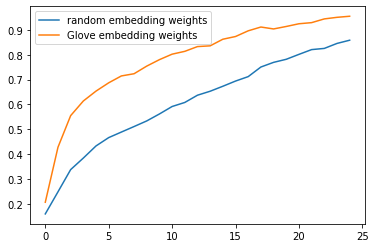

In [73]:
plt.plot(train_acc)
plt.plot(train_glove_acc)
plt.legend(["random embedding weights", "Glove embedding weights"])
plt.show()

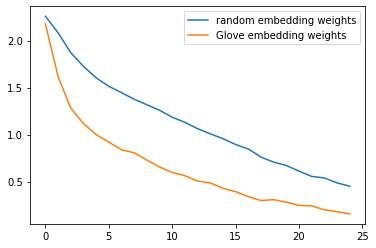

In [74]:
plt.plot(train_loss)
plt.plot(train_glove_loss)
plt.legend(["random embedding weights", "Glove embedding weights"])
plt.show()

## part C)

### build a data loader for train, validation and test


In [75]:
train_data = [[torch.tensor(train_words_vec[i]),train_idxs[i], torch.tensor([train_labels[i]])] for i in range(len(train_labels))][:7110]

In [76]:
test_data = [[torch.tensor(test_words_vec[i]),test_idxs[i], torch.tensor([test_labels[i]])] for i in range(len(test_labels))]

In [77]:
train_set, val_set = torch.utils.data.random_split(train_data, [6600, 510])

In [78]:
def pad_collate(batch):
  (xx,ent, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]
  global padding_idx
  xx_pad = pad_sequence(xx, batch_first=True, padding_value=padding_idx)

  return xx_pad,ent, yy

In [79]:
data_loader = DataLoader(
    dataset=train_set,
    batch_size=128,
    shuffle=True,
    collate_fn=pad_collate
)

In [80]:
validation_loader = DataLoader(
    dataset=val_set,
    batch_size=128,
    shuffle=True,
    collate_fn=pad_collate
)

In [81]:
test_loader = DataLoader(
    dataset=test_data,
    batch_size=128,
    shuffle=True,
    collate_fn=pad_collate
)


### create bi-LSTM model


In [82]:
class BiLSTM(nn.Module):
    
    def __init__(self, embeding_size, vocab_size,num_layer, hidden_size, num_classes, embedding_weights, grad_embedding=True):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        drp = 0.1
        n_classes = num_classes
        self.embedding = nn.Embedding(vocab_size,embeding_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_weights, dtype=torch.float32))
        self.embedding.weight.requires_grad = grad_embedding
        self.lstm = nn.LSTM(input_size = embed_size,num_layers = num_layer, hidden_size = self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*2 , 10)
        self.dropout = nn.Dropout(0.9)
        self.softmax = nn.LogSoftmax(dim=1)
        
        


    def forward(self, x, entities):
        
        h_embedding = self.dropout(self.embedding(x))
        packed_output, (hidden, cell) = self.lstm(h_embedding)

        # max pooling forward and backward
        m = nn.MaxPool1d(2, stride=2)
        output = m(packed_output)
        # average pooling
        my_list = []
        for i in range(x.size(0)):
          e1_indexes = [i for i in entities[i][0]]
          e2_indexes = [i for i in entities[i][1]]
          my_list.append(torch.cat((torch.mean(output[i,e1_indexes,:], dim=0), torch.mean(output[i,e2_indexes,:], dim=0)), dim=0))
          
        cat = torch.stack(my_list)
        conc = self.softmax(self.linear(cat))
        return conc

### train and validate network for some epochs


In [83]:
embed_size = embedding_matrix.shape[1]
hidden_size=150
num_layers=2
vocab_size = embedding_matrix.shape[0]


In [88]:
pooling_model = BiLSTM(embed_size, vocab_size, num_layers,hidden_size, 10, embedding_matrix, grad_embedding=False) # embeding_size, vocab_size,num_layer, hidden_size, num_classes, embedding_wei

In [89]:
pooling_model.to(device)

BiLSTM(
  (embedding): Embedding(24373, 300)
  (lstm): LSTM(300, 150, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=300, out_features=10, bias=True)
  (dropout): Dropout(p=0.9, inplace=False)
  (softmax): LogSoftmax(dim=1)
)

In [90]:
criterion = nn.NLLLoss(ignore_index=padding_idx)
optimizer = optim.Adam(pooling_model.parameters(), lr=0.0005, weight_decay=0.0005)

In [91]:
import time
start_time = time.time()
num_epochs = 25
train_pooling_loss = []
validation_pooling_loss = []
train_pooling_acc=[]
val_pooling_acc = []
for epoch in range(num_epochs):
  running_loss = 0
  running_acc=0
  for idx, (sentence,entity_list, label) in enumerate(iter(data_loader)):

    sentence, label = sentence.to(device),torch.tensor(list(label)).to(device)
    pooling_model.train()
    
      optimizer.zero_grad()
    # Feed forward
      outputs = pooling_model(sentence, entity_list)
    # Calculate the batch loss.
      pred = torch.argmax(outputs, dim=1)
      loss = criterion(outputs, label)
    # Backward pass.
      loss.backward()
    # Update the parameters in the optimizer.
      optimizer.step()   
      running_loss += loss.item()
    running_acc += sum(pred==label).item() /len(label)
  pooling_model.eval()
  running_loss_valid = 0.0
  running_acc_valid = 0.0
  for jdx, (sentence,entity_list, label) in enumerate(iter(validation_loader)):
    sentence, label = sentence.to(device),torch.tensor(list(label)).to(device)
    # Feed forward
    outputs = pooling_model(sentence,entity_list)
    
    loss = criterion(outputs, label)
      
    running_loss_valid += loss.item()

    pred = torch.argmax(outputs, dim=1)
    
    running_acc_valid += sum(pred==label).item()/len(label)


  print(f'epoch: {epoch} -  train loss: {running_loss / (idx+1)} - validation loss: {running_loss_valid/(jdx+1)} - train acc = {running_acc/(idx+1)} - validation acc = {running_acc_valid/(jdx+1)}')
  train_pooling_loss.append(running_loss / (idx+1))
  validation_pooling_loss.append(running_loss_valid/(jdx+1))
  train_pooling_acc.append(running_acc/(idx+1))
  val_pooling_acc.append(running_acc_valid/(jdx+1))
  torch.save(pooling_model.cpu().state_dict(), 'final_model.pth') # saving model
  pooling_model.to(device)

running_time = time.time()-start_time
print(f'training Finished in {running_time} seconds')

epoch: 0 -  train loss: 2.2450805077186 - validation loss: 2.129550874233246 - train acc = 0.16205929487179488 - validation acc = 0.2177579365079365
epoch: 1 -  train loss: 1.9840363974754627 - validation loss: 1.616012841463089 - train acc = 0.297275641025641 - validation acc = 0.4097222222222222
epoch: 2 -  train loss: 1.6592552272173076 - validation loss: 1.4584732353687286 - train acc = 0.41768496260683763 - validation acc = 0.49600074404761907
epoch: 3 -  train loss: 1.5122240827633784 - validation loss: 1.2625480592250824 - train acc = 0.4644931891025641 - validation acc = 0.5569196428571428
epoch: 4 -  train loss: 1.414905188175348 - validation loss: 1.190408855676651 - train acc = 0.5002170138888888 - validation acc = 0.5841393849206349
epoch: 5 -  train loss: 1.369106792486631 - validation loss: 1.0986224710941315 - train acc = 0.5269264155982906 - validation acc = 0.6175285218253969
epoch: 6 -  train loss: 1.3129962063752687 - validation loss: 1.073317527770996 - train acc = 

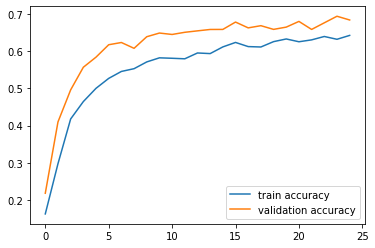

In [92]:
plt.plot(train_pooling_acc)
plt.plot(val_pooling_acc)
plt.legend(["train accuracy", "validation accuracy"])
plt.show()

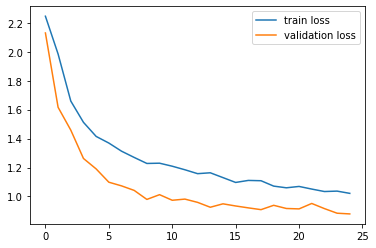

In [93]:
plt.plot(train_pooling_loss)
plt.plot(validation_pooling_loss)
plt.legend(["train loss", "validation loss"])
plt.show()

### test and evaluate model

In [94]:
y_pred_pooling= []
y_label_pooling=[]
with torch.no_grad():
  for jdx, (sentence,entites, label) in enumerate(iter(test_loader)):
    sentence, label = sentence.to(device),torch.tensor(list(label)).to(device)
    # Feed forward
    outputs = pooling_model(sentence, entites)
    pred = torch.argmax(outputs, dim=1)
    for i in range(len(label)):
      y_pred_pooling.append(pred[i].item())
      y_label_pooling.append(label[i].item())


In [95]:
print(f'''accuracy: {accuracy_score(y_label_pooling, y_pred_pooling, normalize=True)} 
\nprecision:{precision_score(y_label_pooling, y_pred_pooling, average='macro')} 
\nrecall: {precision_score(y_label_pooling, y_pred_pooling, average='macro')} 
\nf1 score: {f1_score(y_label_pooling, y_pred_pooling, average='macro')}''')

accuracy: 0.6919396393080604 

precision:0.6877759130570967 

recall: 0.6877759130570967 

f1 score: 0.6855835778655847


In [96]:
!pip install scikit-plot

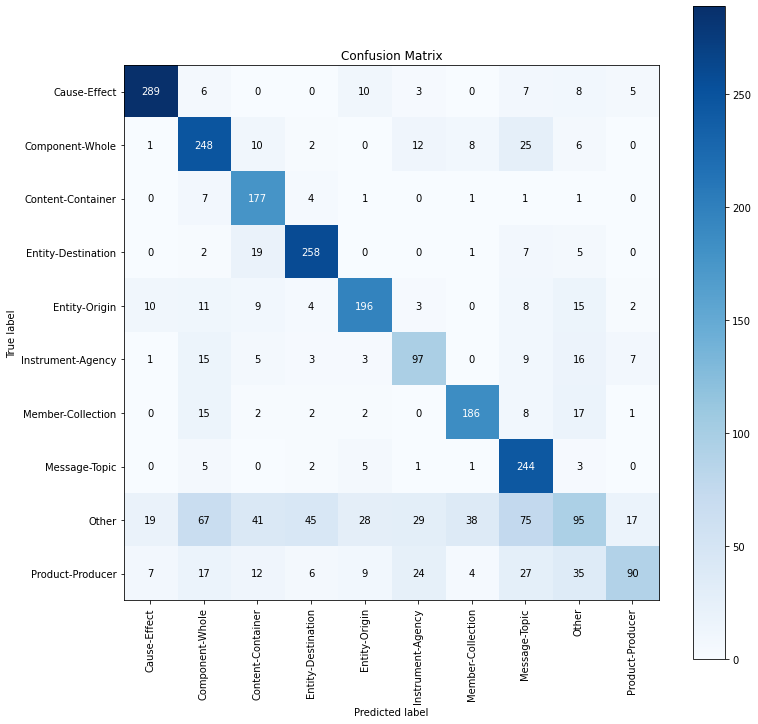

In [97]:
import scikitplot as skplt
y_true = [lb2rel[item] for item in y_label_pooling]
y_pred = [lb2rel[item] for item in y_pred_pooling]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)